## Forecasting Time Series (séries de tempo) utilizando Machine learning. 

Exemplos de modelos: Auto-arima, Prophet e Neural Prophet

Olá, pessoal. Tudo bem? 

Esse é um material bonus, com propósito de ilustrar de maneira prática três algoritmos utilizados para modelar séries de tempo: Auto Arima, Prophet e Neural-Prophet. 

Diferentemente de outros modelos de Machine Learning, os modelos que utilizam séries de tempo dependem exclusivamene de observações feitas sequencialmente ao longo do tempo em que a ordem cronológica é fundamental para a sua aplicalidade.

Ao longo do material vamos percorrer pelos códigos básicos para aplicabilidade desses modelos e conhecer um pouco das funções presentes em cada um dos pacotes. 

Ao fim, fazemos uma breve conclusão extraindo insights e reflexões discutidos ao longo do conteúdo.

Coloquei próximos aos tópicos alguns links de referência para pesquisarem e explorarem. Mas por favor, não limitem a sua curiosidade apenas ao que está contido nesse material, explorem as milhares de outras funções que cada pacote possui.

Bom proveito e espero que gostem!

## O que é séries de tempo?

fonte: 
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

book: https://otexts.com/fpp3/index.html

auto-arima
fone: https://alkaline-ml.com/pmdarima/quickstart.html

In [1]:
!pip install pmdarima
from pmdarima import auto_arima

     |████████████████████████████████| 1.5 MB 5.0 MB/s 
     |████████████████████████████████| 9.5 MB 53.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [74]:
# IMPORTs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from statsmodels.tsa.stattools import adfuller,acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pylab import rcParams

import math

#Auto arima
import pmdarima as pm
from pmdarima import utils
from pmdarima.datasets import load_wineind


In [13]:
# This time-series records total wine sales by Australian wine makers in bottles <= 1 litre between Jan 1980 – Aug 1994.
vinho = load_wineind(True).astype(np.float64)

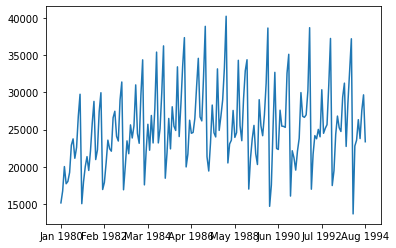

In [14]:
vinho.plot()

In [71]:
vinho.tail()

ds        y
ds                          
Apr 1994 1994-04-01  26323.0
May 1994 1994-05-01  23779.0
Jun 1994 1994-06-01  27549.0
Jul 1994 1994-07-01  29660.0
Aug 1994 1994-08-01  23356.0

In [15]:
type(vinho)

pandas.core.series.Series

In [16]:
vinho = vinho.to_frame().reset_index()
vinho = vinho.rename(columns={'index':'ds',0:'y'})
vinho = vinho.set_index(vinho.ds)

In [17]:
vinho['ds']= pd.to_datetime(vinho.ds) 
vinho.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176 entries, Jan 1980 to Aug 1994
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      176 non-null    datetime64[ns]
 1   y       176 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1+ KB


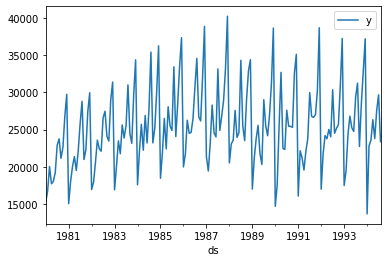

In [18]:
vinho.plot(x='ds',y='y')

In [76]:
figure_kwargs_1 =  {'figsize': (20, 6)}  # set figure size for both examples

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


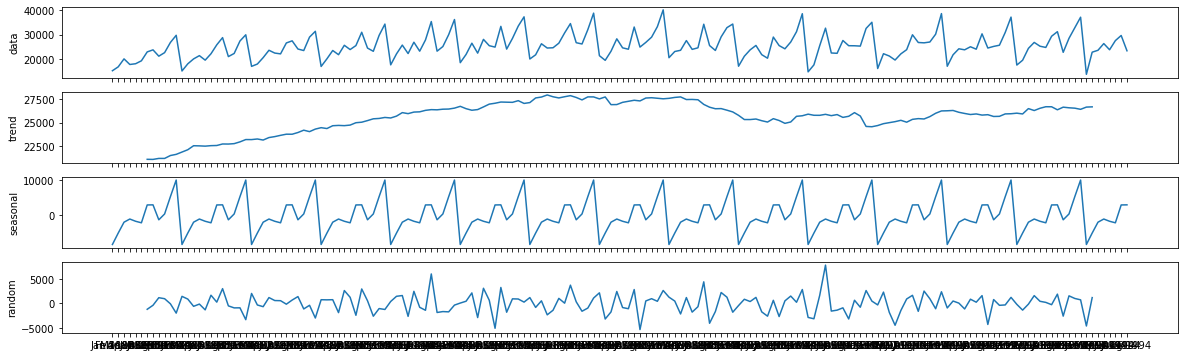

In [77]:
decomp = pm.decompose(x=vinho['y'],type_='additive',m=12)
axes = utils.decomposed_plot(decomp, figure_kwargs_1,show=False)

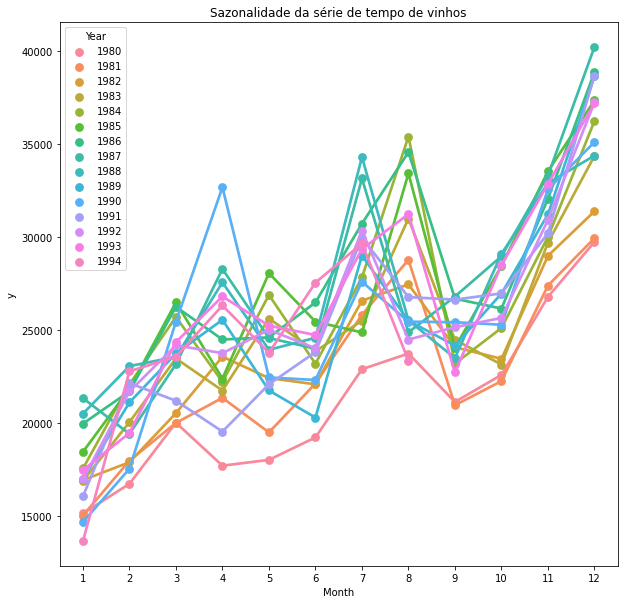

In [21]:
vinho_test = vinho.copy()
vinho_test['Year'] = pd.DatetimeIndex(vinho_test.index).year
vinho_test['Month'] = pd.DatetimeIndex(vinho_test.index).month

# Stacked line plot
plt.figure(figsize=(10,10))
plt.title('Sazonalidade da série de tempo de vinhos')
sns.pointplot(x='Month',y='y',hue='Year',data=vinho_test)

# Preparando o dataset

In [22]:
# FUnção para split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [23]:
# definindo o tamanho do corte entre teste e treinamento
n_test = int(0.2*len(vinho))
n_test

35

In [24]:
train_vinho,test_vinho = train_test_split(vinho, n_test)
train_vinho.info()

<class 'pandas.core.frame.DataFrame'>
Index: 141 entries, Jan 1980 to Sep 1991
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      141 non-null    datetime64[ns]
 1   y       141 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.3+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  This is separate from the ipykernel package so we can avoid doing imports until


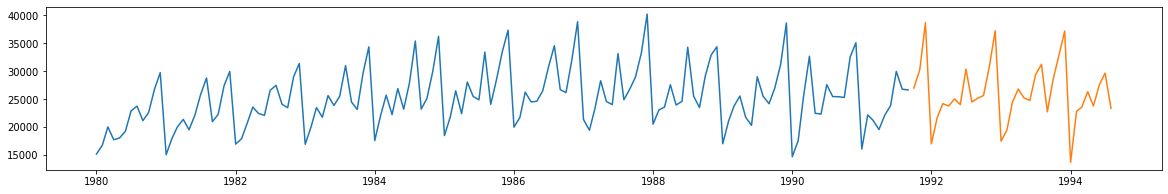

In [25]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot('ds','y',data=train_vinho)
plt.plot('ds','y',data=test_vinho)

#Auto Arima

In [26]:
vinho_2 = load_wineind(True).astype(np.float64)

In [27]:
n_test_2 = int(0.2*len(vinho_2))

In [28]:
train_vinho_2,test_vinho_2 = train_test_split(vinho_2, n_test)

In [29]:
wine = pm.auto_arima(train_vinho_2,seasonal = True)

In [30]:
wine.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  141
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -1393.179
Date:                Tue, 24 Aug 2021   AIC                           2798.359
Time:                        22:36:30   BIC                           2816.009
Sample:                             0   HQIC                          2805.531
                                - 141                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2070      0.130      1.595      0.111      -0.047       0.461
ar.L2         -0.2210      0.148     -1.492      0.136      -0.511       0.069
ar.L3          0.0436      0.126      0.347      0.728      -0.202       0.290
ar.L4          0.1370      0.124      1.108      0.268      -0.105       0.379
ma.L1         -0.9134      0.076    -11.951      0.000      -1.063      -0.764
sigma2      2.739e+07   1.87e-09   1.46e+16      0.000    2.74e+07    2.74e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.77
Prob(Q):                              0.83   Prob(JB):                         0.41
Heteroskedasticity (H):               1.46   Skew:                            -0.26
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.84e+31. Standard errors may be unstable.
"""

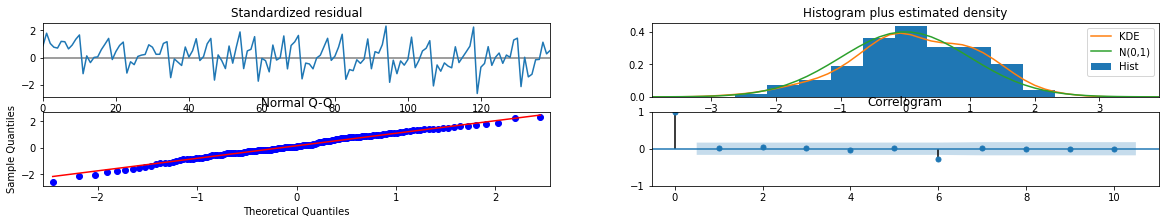

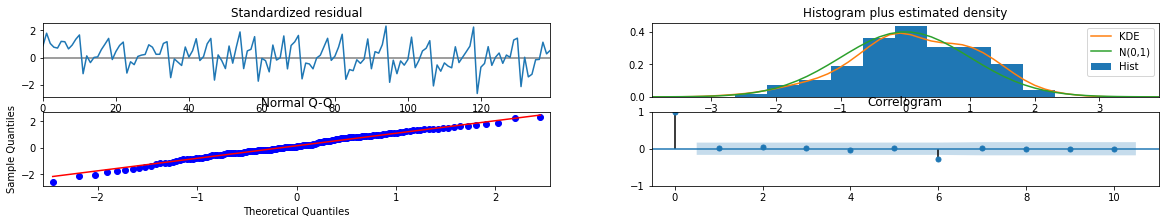

In [31]:
wine.plot_diagnostics()

In [32]:
arima_forecast = wine.predict(n_periods=35)

In [33]:
arima_forecast_frame = np.array(arima_forecast).T.tolist()
arima_forecast_frame = pd.DataFrame(arima_forecast_frame)
arima_forecast_frame = arima_forecast_frame.rename(columns={0:'y_hat'})
arima_forecast_frame['ds'] = test_vinho['ds'].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  """Entry point for launching an IPython kernel.


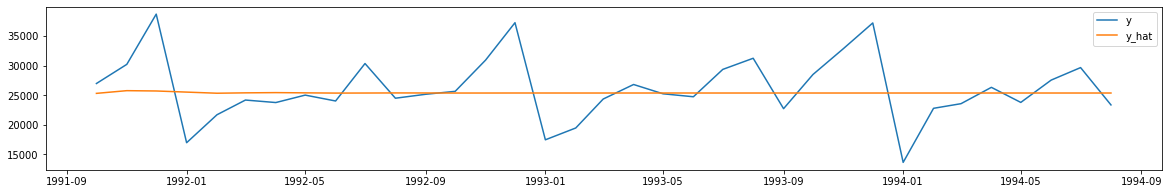

In [34]:
plt.plot('ds','y',data= test_vinho) # plot first line
plt.plot('ds','y_hat',data= arima_forecast_frame) # plot second line
plt.legend()
plt.show()

# Muito calma nessa hora, galera. Dá para arrumar esse fit!

In [78]:
wine_2 = pm.auto_arima(train_vinho_2, start_p=1, start_q=1,
                             max_p=3, max_q=3, m=12,
                             start_P=0, seasonal=True,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2417.615, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2456.181, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2438.551, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2418.799, Time=0.20 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2426.745, Time=0.14 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2417.956, Time=0.67 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=2418.337, Time=1.04 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2419.877, Time=0.35 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=2419.908, Time=2.07 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2436.317, Time=0.18 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=2417.873, Time=0.46 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=2417.637, Time=1.25 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2451.230, Time=0.34 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2416.802, Time=0.30 sec
 ARIMA(0,1,2)(0,1,0

In [79]:
wine_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  141
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1203.377
Date:                              Tue, 24 Aug 2021   AIC                           2416.754
Time:                                      23:29:27   BIC                           2431.014
Sample:                                           0   HQIC                          2422.548
                                              - 141                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4701      0.045    -10.335      0.000      -0.559      -0.381
ma.L2         -0.1750      0.049     -3.574      0.000      -0.271      -0.079
ar.S.L12       0.3882      0.197      1.974      0.048       0.003       0.774
ma.S.L12      -0.6710      0.184     -3.656      0.000      -1.031      -0.311
sigma2      7.618e+06   7.95e+05      9.586      0.000    6.06e+06    9.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.07   Jarque-Bera (JB):                11.86
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.34   Skew:                            -0.49
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

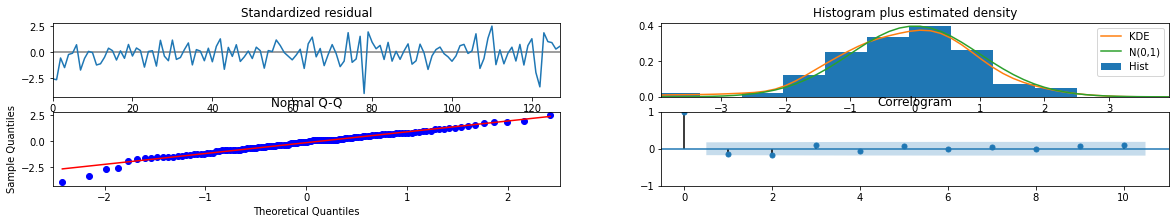

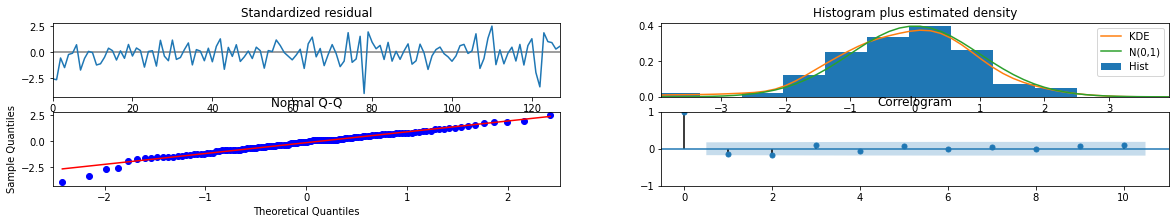

In [37]:
wine_2.plot_diagnostics()

In [38]:
arima_forecast_2 = wine_2.predict(n_periods=35)

In [39]:
arima_forecast_frame_2 = np.array(arima_forecast_2).T.tolist()
arima_forecast_frame_2 = pd.DataFrame(arima_forecast_frame_2)
arima_forecast_frame_2 = arima_forecast_frame_2.rename(columns={0:'y_hat'})
arima_forecast_frame_2['ds'] = test_vinho['ds'].reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  """Entry point for launching an IPython kernel.


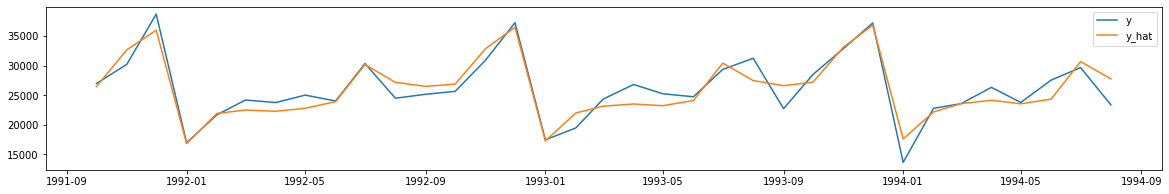

In [40]:
plt.plot('ds','y',data= test_vinho) # plot first line
plt.plot('ds','y_hat',data= arima_forecast_frame_2) # plot second line
plt.legend()
plt.show()

In [41]:
erro_2=np.abs(np.array(test_vinho['y'])-np.array(arima_forecast_frame_2['y_hat']))
MAE_2 = erro_2.mean()
MAE_2

1592.0263166017785

In [42]:
erro=np.abs(np.array(test_vinho['y'])-np.array(arima_forecast_frame['y_hat']))
MAE = erro.mean()
MAE

3965.1105429255604

In [43]:
test_vinho['y'].mean()

26168.485714285714

In [44]:
MAE / test_vinho['y'].mean()

0.1515223534986954

In [45]:
mae_perc_arima = MAE_2 / test_vinho['y'].mean()
mae_perc_arima

0.06083754077266575

In [46]:
MSE_2 = np.square(erro).mean()
MSE_2

29221705.753567852

In [47]:
RMSE_2 = math.sqrt(MSE_2)
RMSE_2

5405.710476298916

# Prophet

bibliografia: https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [48]:
!pip install prophet

     |████████████████████████████████| 65 kB 2.3 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 178 kB 18.9 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640469 sha256=55c4f3dd7ddf495e6f94069fa6838cc63c2847e0d0779966bf136a6fed73c48e
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [49]:
from prophet import Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


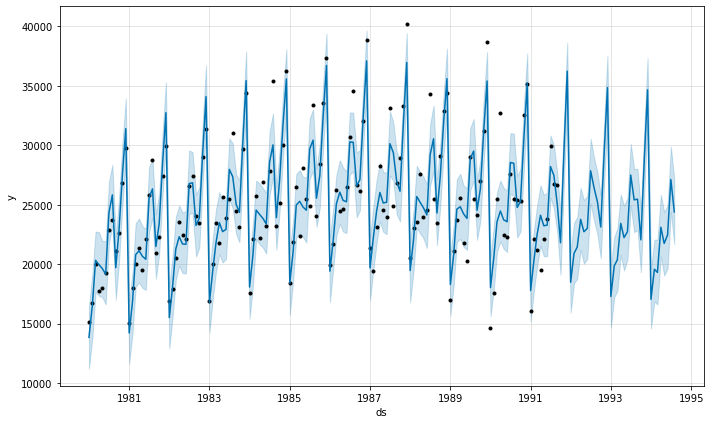

In [50]:
#Prophet
m = Prophet(yearly_seasonality=True) 
m.fit(train_vinho)
future = m.make_future_dataframe(freq='M',periods=35)
forecast = m.predict(future)
forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
m.plot(forecast)
projetado = forecast[['ds', 'yhat']]

In [82]:
forecast.tail()

ds          yhat    yhat_lower    yhat_upper
171 1994-03-31  23102.977237  20651.601586  25848.243026
172 1994-04-30  21744.140488  19035.205818  24376.723876
173 1994-05-31  22453.582364  19629.495689  24948.201087
174 1994-06-30  27117.497519  24393.319757  29897.550613
175 1994-07-31  24393.112284  21680.406914  27116.767286

In [51]:
projetado_prophet = projetado[-n_test:]
projetado_prophet

ds          yhat
141 1991-09-30  21797.936013
142 1991-10-31  29416.422298
143 1991-11-30  36230.751942
144 1991-12-31  18476.378379
145 1992-01-31  20906.172451
146 1992-02-29  21431.992364
147 1992-03-31  23769.149948
148 1992-04-30  22728.207999
149 1992-05-31  23006.730469
150 1992-06-30  27853.202334
151 1992-07-31  26429.620073
152 1992-08-31  25234.681241
153 1992-09-30  23129.422542
154 1992-10-31  29344.555605
155 1992-11-30  34843.124541
156 1992-12-31  17287.174841
157 1993-01-31  19857.028824
158 1993-02-28  20366.991040
159 1993-03-31  23432.155297
160 1993-04-30  22234.173999
161 1993-05-31  22729.394481
162 1993-06-30  27490.291435
163 1993-07-31  25409.232544
164 1993-08-31  25466.420070
165 1993-09-30  22047.973458
166 1993-10-31  28715.001119
167 1993-11-30  34661.007318
168 1993-12-31  17040.150794
169 1994-01-31  19575.126186
170 1994-02-28  19302.782130
171 1994-03-31  23102.977237
172 1994-04-30  21744.140488
173 1994-05-31  22453.582364
174 1994-06-30  27117.497519
175 1994-07-31  24393.112284

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.



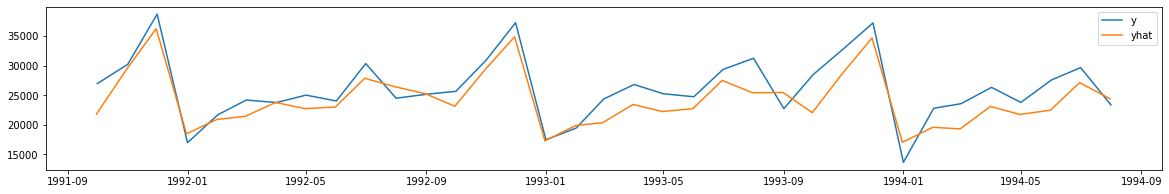

In [52]:
plt.plot('ds','y',data= test_vinho) # plot first line
plt.plot('ds','yhat',data= projetado_prophet) # plot second line
plt.legend()
plt.show()

In [53]:
erro_prohet=np.abs(np.array(test_vinho['y'])-np.array(projetado_prophet['yhat']))
MAE_prohet = erro_prohet.mean()
MAE_prohet

2544.729188529701

In [54]:
mae_perc_prophet = MAE_prohet / test_vinho['y'].mean()
mae_perc_prophet

0.09724403682787423

In [55]:
MSE_prohet = np.square(erro_prohet).mean()
MSE_prohet

8948837.547429573

In [56]:
RMSE_prohet = math.sqrt(MSE_prohet)
RMSE_prohet

2991.4607715010357

#Neural prophet
fonte: 
- https://github.com/ourownstory/neural_prophet
- http://neuralprophet.com/
- apresentação: https://github.com/ourownstory/neural_prophet/blob/master/notes/Presented_at_International_Symposium_on_Forecasting.pdf

In [57]:
!pip install git+https://github.com/ourownstory/neural_prophet.git

  Cloning https://github.com/ourownstory/neural_prophet.git to /tmp/pip-req-build-xwl1b6gx
  Running command git clone -q https://github.com/ourownstory/neural_prophet.git /tmp/pip-req-build-xwl1b6gx
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for neuralprophet: filename=neuralprophet-0.2.8-py3-none-any.whl size=58100 sha256=40734bf84be9b96a480f168b8c501a579a925e114007d8c227d2058b18e8a6cb
  Stored in directory: /tmp/pip-ephem-wheel-cache-v0ff4uq0/wheels/bc/d0/dd/f2b1133865669ed9b544f6f1ff9155aedf57c9dbfc72ce211e
Successfully built neuralprophet


In [83]:
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import utils

In [84]:
data = train_vinho
period = 35

#colocando o modelo para rodar
model_neural = NeuralProphet(
    n_forecasts=period,n_lags=1,yearly_seasonality=True)
# fit model
metrics_neural = model_neural.fit(data,freq='MS')
future_neural = model_neural.make_future_dataframe(data,  n_historic_predictions=True)
forecast_neural = model_neural.predict(future_neural)
results_neural = utils.fcst_df_to_last_forecast(forecast_neural, n_last=1)[-(model_neural.n_forecasts+ model_neural.n_lags):]
# estimate prediction error

results_3= results_neural[['ds','yhat1']][(-period):].reset_index(drop=True)

INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:NP.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 293
INFO:NP.config:Auto-set epochs to 293


  0%|          | 0/203 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 9.34E-02, min: 2.76E+00
INFO:NP.utils_torch:lr-range-test results: steep: 9.34E-02, min: 2.76E+00
INFO - (NP.utils_torch.lr_range_test) - learning rate range test selected lr: 8.92E-01
INFO:NP.utils_torch:learning rate range test selected lr: 8.92E-01
Epoch[293/293]: 100%|██████████| 293/293 [00:07<00:00, 39.51it/s, SmoothL1Loss=0.00536, MAE=1.6e+3, MSE=4.24e+6, RegLoss=0]


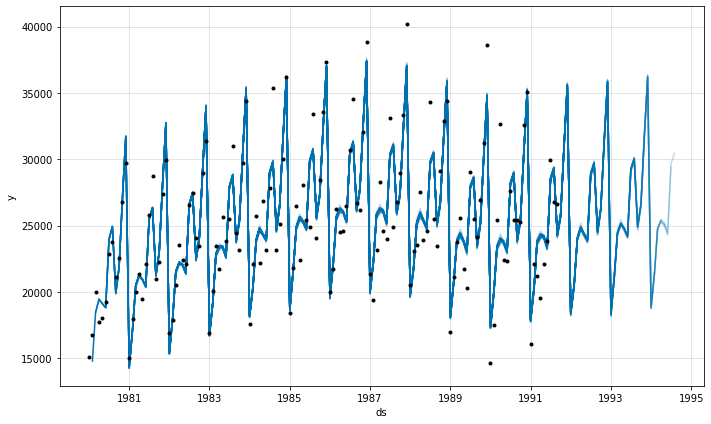

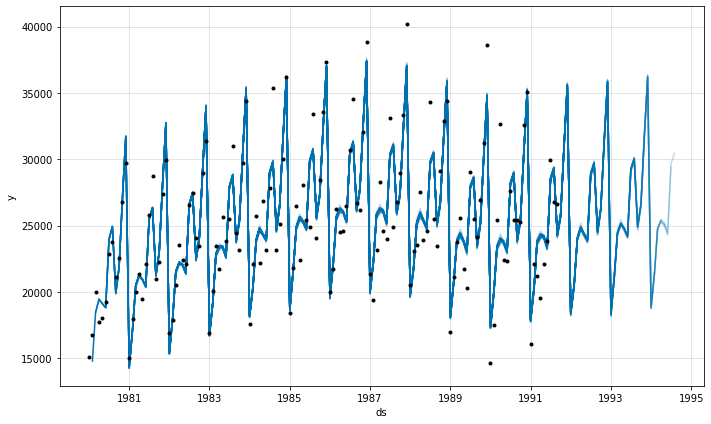

In [85]:
#gerando gráficos observado vs estimado (função incluída dentro do pacote)
model_neural.plot(forecast_neural)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning:

Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.



Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.




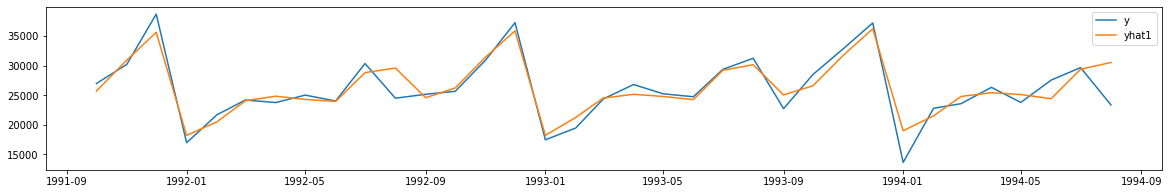

In [61]:
plt.plot('ds','y',data= test_vinho) # plot first line
plt.plot('ds','yhat1',data= results_3) # plot second line
plt.legend()
plt.show()

In [62]:
erro_neural=np.abs(np.array(test_vinho['y'])-np.array(results_3['yhat1']))
MAE_neural = erro_neural.mean()
MAE_neural

1503.302232142857

In [63]:
mae_perc_neural = MAE_neural / test_vinho['y'].mean()
mae_perc_neural

0.05744704712975367

In [64]:

MSE_neural = np.square(erro_neural).mean()
MSE_neural

4633110.098535374

In [65]:
RMSE_neural = math.sqrt(MSE_neural)
RMSE_neural

2152.466050495425

#Conclusões

In [66]:
!pip install tabulate

In [67]:
from tabulate import tabulate

In [68]:
#construindo uma tabela maneira compilando os resultados. Primeiro, fiz um dicionário para depois transformar em tabela com o pacote tabulate.
tabela = {'Modelos': ['Auto-Arima ajustado','Prophet','Neural Prophet']
          ,'MAE':[round(MAE_2),round(MAE_prohet),round(MAE_neural)]
          ,'MAE %':[round(mae_perc_arima,4),round(mae_perc_prophet,4),round(mae_perc_neural,4)]
          ,'MSE':[round(MSE_2),round(MSE_prohet),round(MSE_neural)]
          ,'RMSE':[RMSE_2,RMSE_prohet,RMSE_neural]}

In [69]:
#imprimindo os resultados
print(tabulate(tabela,headers='keys',tablefmt='fancy_grid'))

╒═════════════════════╤═══════╤═════════╤══════════╤═════════╕
│ Modelos             │   MAE │   MAE % │      MSE │    RMSE │
╞═════════════════════╪═══════╪═════════╪══════════╪═════════╡
│ Auto-Arima ajustado │  1592 │  0.0608 │ 29221706 │ 5405.71 │
├─────────────────────┼───────┼─────────┼──────────┼─────────┤
│ Prophet             │  2545 │  0.0972 │  8948838 │ 2991.46 │
├─────────────────────┼───────┼─────────┼──────────┼─────────┤
│ Neural Prophet      │  1503 │  0.0574 │  4633110 │ 2152.47 │
╘═════════════════════╧═══════╧═════════╧══════════╧═════════╛


De maneira geral, o auto arima mostrou-se um modelo muito eficiente para projeção. A única ressalva é que apesar do auto arima ser um algoritmo de ajuste "automatico", ainda sim seria interessante maior aprofundamento em conceitos e teorias de 'time series' para melhor ajustar os parametros. 

Nesse sentido, os algoritmos "Prophet" e "Neural Prophet" levam vantagem em relação à aplicabilidade. Claro que o conhecimento de time series também é importante para atingir ajustes mais interessantes em diferentes tipos de contextos, mas pensando em termos de automotização, esses dois modelos se mostram muito mais fáceis de serem implementados em uma esteira de automatização e escalonamento de processos. 

Por qual motivo é importante escalar e automotizar? Nem sempre temos tempo e conhecimento suficiente para rodar todos os modelos da maneira que desejamos. Muitas vezes, é uma tarefa humanamente impossível projetar mais de 100, 500 ou quiça mais de 1 k modelos. Por esse motivo, o cientista de dados deve levar em consideração esses aspectos também de automoção de processo dentro do contexto corporativo. 

Em comparação estrita entre o prophet e o neural prophet, acredito ser uma questão de ocasião e de preferência. O neural é uma tecnologia muito sofisticada e atual. Os recursos aplicados são de última geração (até o momento). Mas isso não significa dizer que o Prophet não tenha o seu charme. Além dele não necessitar o pytorch instalado na máquina ou gpu on-line, o prophet é mais simples e intuitivo de entender. 

Minha sugestão é buscarem no google os milhares de tutoriais que há desses três modelos e tantos outros de time series. Investiguem, pesquisem, leiam os paper e documentos, tudo isso agrega muito para nos mantermos atualizados e aprender coisas novas. 

O legal dessa jornada de aprendizado é que nunca chegamos ao fim, sempre há mais caminhos e destinos para conhecermos e explorarmos. 

É isso, galera, espero que tenham gostado. Qualquer coisa, só me chamar no email ou no linkedin.

Um abraço! 

Jonas

email: jonas.ok@gmail.com

linkedin: https://www.linkedin.com/in/jonas-manabu-okawara/
